#### pwd

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import json
import os
import re
import shutil
import sys
import time
import yaml
from collections import defaultdict
from dataclasses import astuple, asdict, dataclass
from datetime import datetime, timedelta
from glob import glob
from operator import itemgetter
from pathlib import Path
from pprint import pprint

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import ndimage as ndi

In [13]:
from sam2.utils.misc import get_connected_components

from train_image_predictor import read_single, get_point_prompt, get_box_prompt, display_example, HDF5ImageIndexer

In [5]:
config_path = 'train_config.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)
config

{'train_data_config': {'data_files': {'vol_12350': {'image': {'path': '/home/eschomburg/Simons Foundation Dropbox/Erik Schomburg/wasp-em/13_wasp_sample3_neuron/vol_01700/img.h5',
     'dataset': 'main'},
    'label': {'path': '/home/eschomburg/Simons Foundation Dropbox/Erik Schomburg/wasp-em/13_wasp_sample3_neuron/vol_01700/label_v3_filled.h5',
     'dataset': 'main'}}},
  'patch_size': [200, 200],
  'axis': None,
  'rng': 'she sells sea shells by the sea shore'},
 'sam2_checkpoint': 'sam2_hiera_small.pt',
 'model_cfg': 'sam2_hiera_s.yaml',
 'batch_size': 4,
 'num_batches': 1000,
 'learning_rate': 1e-05,
 'weight_decay': 4e-05,
 'checkpoint_interval': 1000,
 'display_interval': 100}

In [6]:
data_indexer = HDF5ImageIndexer.from_config(config['train_data_config'])

In [7]:
image, mask, data_index = read_single(data_indexer)

In [8]:
data_index

DataFiles(image=HDF5DataIndex(path='/home/eschomburg/Simons Foundation Dropbox/Erik Schomburg/wasp-em/13_wasp_sample3_neuron/vol_01700/img.h5', dataset='main', slice=(slice(17, 217, None), slice(15, 215, None), 107)), label=HDF5DataIndex(path='/home/eschomburg/Simons Foundation Dropbox/Erik Schomburg/wasp-em/13_wasp_sample3_neuron/vol_01700/label_v3_filled.h5', dataset='main', slice=(slice(17, 217, None), slice(15, 215, None), 107)))

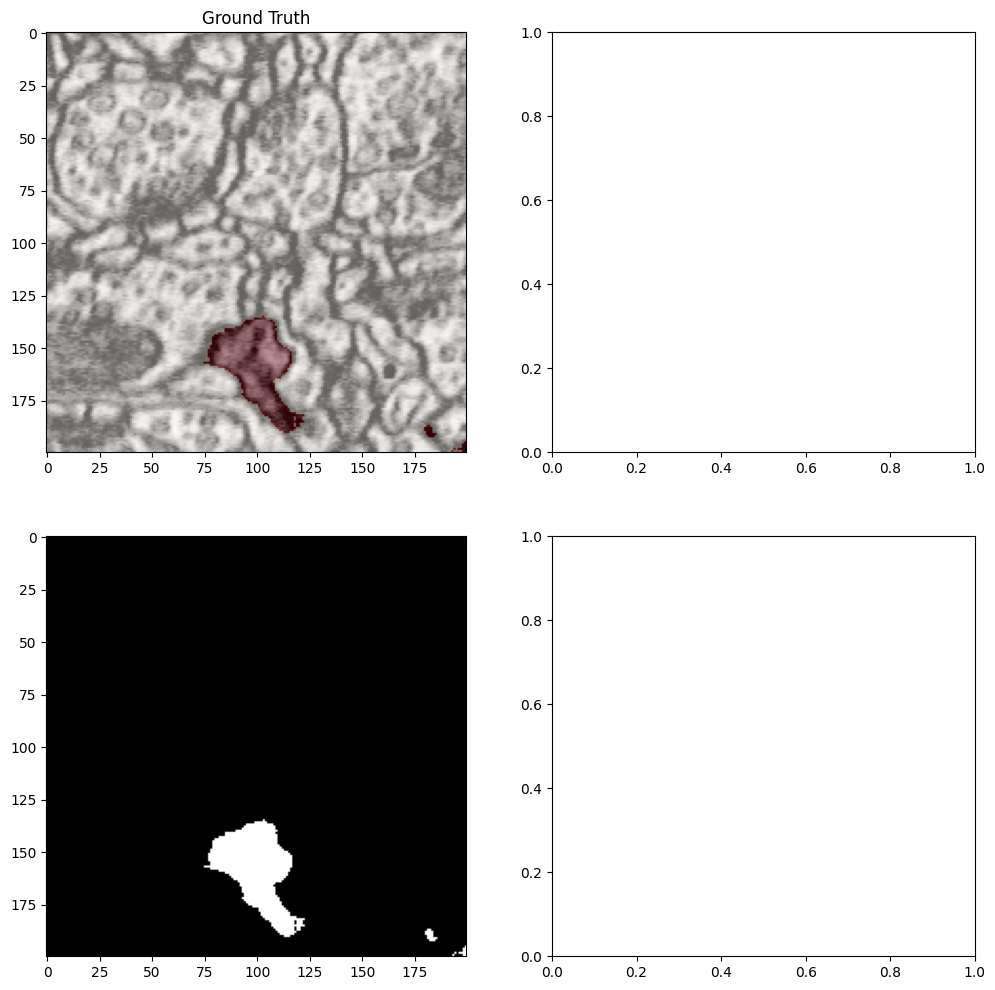

In [9]:
display_example(image, mask)

In [10]:
mask_dt = ndi.distance_transform_edt(mask)
com = ndi.center_of_mass(mask)[::-1]

In [20]:
gpu = torch.device('cuda')
gpu

device(type='cuda')

In [23]:
mask_cc = get_connected_components(torch.tensor(mask).reshape(1, 1, *mask.shape).to(gpu))
mask_cc

[tensor([[[[    0,     0,     0,  ...,     0,     0,     0],
           [    0,     0,     0,  ...,     0,     0,     0],
           [    0,     0,     0,  ...,     0,     0,     0],
           ...,
           [    0,     0,     0,  ...,     0, 38999, 38999],
           [    0,     0,     0,  ..., 38999, 38999, 38999],
           [    0,     0,     0,  ...,     0, 38999, 38999]]]], device='cuda:0',
        dtype=torch.int32),
 tensor([[[[ 0,  0,  0,  ...,  0,  0,  0],
           [ 0,  0,  0,  ...,  0,  0,  0],
           [ 0,  0,  0,  ...,  0,  0,  0],
           ...,
           [ 0,  0,  0,  ...,  0, 11, 11],
           [ 0,  0,  0,  ..., 11, 11, 11],
           [ 0,  0,  0,  ...,  0, 11, 11]]]], device='cuda:0',
        dtype=torch.int32)]

In [29]:
np.unique(mask, return_counts=True)

(array([0, 1], dtype=uint8), array([38737,  1263]))

In [27]:
np.unique(mask_cc[1].cpu().numpy(), return_counts=True)

(array([   0,    2,   11,   21, 1229], dtype=int32),
 array([38737,     2,    11,    21,  1229]))

In [28]:
np.unique(mask_cc[0].cpu().numpy(), return_counts=True)

(array([    0, 26903, 37381, 38999, 39793], dtype=int32),
 array([38737,  1229,    21,    11,     2]))

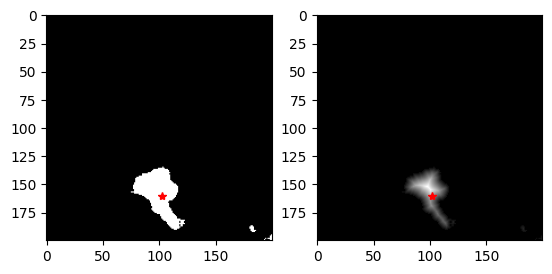

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask, cmap='grey')
axs[0].plot(*com, marker='*', color='r')
axs[1].imshow(mask_dt, cmap='grey')
axs[1].plot(*com, marker='*', color='r')
plt.show()